In [2]:
!pip install pandas openpyxl
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=44796d90a1f471efb7af154402114afd71a135afad989bdd9f0ad007a92c4b1d
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [92]:
import pandas as pd
import openpyxl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
#survival analysis libraries
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter


In [93]:
employee_df = pd.read_excel('/content/Employee.xlsm', engine='openpyxl')
performanceReview_df = pd.read_excel('/content/Performancereview.xlsm', engine='openpyxl')
Survey_df = pd.read_excel('/content/Survey.xlsm', engine='openpyxl')

In [94]:
# Handle missing values
employee_df['DegreeField'].fillna('Unknown', inplace=True)
employee_df['MaritalStatus'].fillna('Unknown', inplace=True)
employee_df['NumPreviousCompanies'].fillna(0, inplace=True)
employee_df['EmploymentEndReason'].fillna('Unknown', inplace=True)

# Convert date columns to datetime
employee_df['EmploymentEndDate'] = pd.to_datetime(employee_df['EmploymentEndDate'])
employee_df['EmploymentStartDate'] = pd.to_datetime(employee_df['EmploymentStartDate'])

# Encode categorical variables
#employee_df = pd.get_dummies(employee_df, columns=['Gender', 'TravelFrequency', 'MaritalStatus'], drop_first=True)

In [95]:
# To check if NaT in EmploymentEndDate means that the employee is still not churned
subset_df = employee_df[(employee_df['EmploymentEndDate'].isna()) & (employee_df['EmploymentEndReason'] == 'Unknown')]
subset_df1 = employee_df[(employee_df['EmploymentEndDate'].isna())]
print(subset_df1.shape)
print(subset_df.shape)

(1280, 20)
(1280, 20)


In [96]:
# Define the attrition variable
def determine_attrition(end_date, reason):
    if pd.isna(end_date):
        return 'No Attrition'
    elif reason in ['Went to another company', 'Retired', 'Fired']:
        return 'Yes'
    else:
        return 'No Attrition'
employee_df['Attrition'] = employee_df.apply(lambda row: determine_attrition(row['EmploymentEndDate'], row['EmploymentEndReason']), axis=1)


In [97]:
(employee_df.shape)

(2001, 21)

In [98]:
# Merge the dataframes on 'EmployeeId'
merged_df = pd.merge(employee_df, performanceReview_df, on='EmployeeId', how='inner')
merged_df = pd.merge(merged_df, Survey_df, on='EmployeeId', how='inner')

In [99]:
#feature Engineering
merged_df['Age'] = merged_df['ReviewDate'].dt.year - merged_df['YearOfBirth']
merged_df['Tenure'] = merged_df['NumYearsWorked'] + (merged_df['ReviewDate'] - merged_df['EmploymentStartDate']).dt.days / 365
merged_df['EmploymentDuration'] = (merged_df['ReviewDate'] - merged_df['EmploymentStartDate']).dt.days
merged_df['PerformanceRatingDiff'] = merged_df.groupby('EmployeeId')['PerformanceRating'].diff()
merged_df['ReviewYear'] = merged_df['ReviewDate'].dt.year
merged_df['ReviewMonth'] = merged_df['ReviewDate'].dt.month
# Define a threshold for being overworked
overtime_threshold = 40
merged_df['Overworked'] = (merged_df['OvertimeHours'] > overtime_threshold) | (merged_df['OvertimeDays'] > 0)



In [100]:
# Analysing the percentage of trend over period of years starting frm 2005
attr_percentage=employee_df.copy()
attr_percentage['EmploymentEndMonth'] = (attr_percentage['EmploymentStartDate']).dt.year
#attr_percentage['EmploymentEndDate'].fillna('0',inplace=True)
attr_percentage = attr_percentage.groupby('EmploymentEndMonth')['Attrition'].value_counts(normalize=True).unstack(fill_value=0)['Yes'] * 100
attr_percentage = pd.Series(attr_percentage).reset_index()
attr_percentage.columns = ['Year', 'Attrition Percentage']
attr_percentage=attr_percentage[attr_percentage['Year']>=2005]
fig = px.line(attr_percentage, x='Year', y='Attrition Percentage', title='Attrition Trend by Year')
fig.update_traces(mode='markers+lines', marker=dict(size=8))

# Customize the layout
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Attrition Percentage (%)',
    legend_title='Attrition'
)
# Show the interactive chart
fig.show()

**In the above plot the attrition rate has steadily decreased from 90% in 2005 to 40.75% in 2019, indicating a positive trend in employee retention over the years. Although there are minor fluctuations, the overall attrition trend shows a significant improvement, with 2010 being a turning point leading to lower attrition rates.**

In [101]:
high_attrition_years = [2006, 2007, 2011,2019]  # Replace with your actual high attrition years
attr_year=employee_df.copy()
attr_year['EmploymentEndMonth'] = (attr_year['EmploymentStartDate']).dt.year

filtered_df = attr_year[attr_year['EmploymentEndMonth'].isin(high_attrition_years)]
# Filter data for high attrition years
# Analyze overtime
average_overtime_days = filtered_df.groupby('EmploymentEndMonth')['OvertimeDays'].mean()
average_overtime_hours = filtered_df.groupby('EmploymentEndMonth')['OvertimeHours'].mean()

# Create a DataFrame for the averages
average_data = pd.DataFrame({
    'EmploymentEndMonth': average_overtime_days.index,
    'Average Overtime Days': average_overtime_days.values,
    'Average Overtime Hours': average_overtime_hours.values
})

# Create an interactive line chart with Plotly
fig = px.line(average_data, x='EmploymentEndMonth', y=['Average Overtime Days', 'Average Overtime Hours'],
              labels={'value': 'Average Overtime', 'EmploymentEndMonth': 'Highest Attrition Years'},
              title='Overtime Analysis during High Attrition Years')

# Show the interactive chart
fig.show()

**During high attrition years, such as 2006 and 2019, employees worked an average of approximately 3.64 to 3.66 extra days, reflecting an increased workload.Despite the fluctuation in average overtime hours, employees in 2007 worked the fewest hours, suggesting variations in work intensity during these high attrition periods.**

In [102]:
# Calculate survey response frequencies for each year
high_attrition_years = [2006, 2007, 2011]
survey_year=merged_df.copy()
survey_year['EmploymentEndMonth'] = (survey_year['EmploymentStartDate']).dt.year
filtered_df = survey_year[survey_year['EmploymentEndMonth'].isin(high_attrition_years)]
survey_responses = filtered_df.groupby(['EmploymentEndMonth', 'QuestionText'])['Response'].value_counts().reset_index(name='Frequency')


import plotly.express as px
for year in high_attrition_years:
    year_data = survey_responses[survey_responses['EmploymentEndMonth'] == year]
    year_data = year_data.groupby(['Response']).size().reset_index(name='Frequency')
    year_data['Attrition Percentage'] = (year_data['Frequency'] / year_data['Frequency'].sum()) * 100
    fig = px.bar(year_data, x='Response', y='Attrition Percentage',
                 title=f'Attrition Percentages by Survey Response in {year}',
                 labels={'Attrition Percentage': 'Attrition Percentage (%)'},
                 text='Attrition Percentage', width=800, height=500)

    fig.update_traces(texttemplate='%{text:.2f}%',  textposition='outside')
    fig.update_xaxes(type='category')
    fig.show()


**In 2006, a significant 30% attrition rate was observed among employees who reported being "Very Satisfied," highlighting that even highly satisfied employees were affected by attrition during this period.**

**In 2007, employees who rated themselves as "Neither Satisfied nor Unsatisfied" had a notable attrition rate of 25%, indicating that employees with mixed feelings or indifference were more likely to leave that year.**

**In 2011, the attrition pattern varied across different responses. "Neither Satisfied nor Unsatisfied" and "Somewhat Satisfied" employees had the highest attrition rate at 15.79%, suggesting that those with moderate satisfaction levels were more susceptible to attrition during this period.**

In [103]:
import matplotlib.pyplot as plt

high_attrition_years = [2006, 2007, 2011,2019]  # Replace with your actual high attrition years
performance_year=merged_df.copy()
# Extract the year from EmploymentStartDate
performance_year['EmploymentEndMonth'] = performance_year['EmploymentStartDate'].dt.year

# Filter the data for high attrition years
filtered_df = performance_year[performance_year['EmploymentEndMonth'].isin(high_attrition_years)]

# Calculate performance rating percentages for each year
performance_percentages = filtered_df.groupby(['EmploymentEndMonth'])['PerformanceRating'].value_counts(normalize=True).reset_index(name='Percentage')

# Create an interactive bar chart using Plotly Express
fig = px.bar(performance_percentages, x='PerformanceRating', y='Percentage',
             title='Performance Ratings Percentage in High Attrition Years',
             labels={'PerformanceRating': 'Performance Rating', 'Percentage': 'Percentage'},
             text='Percentage',
             facet_col='EmploymentEndMonth')

fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')

fig.show()


**In 2006, employees with a performance rating of 3 had the highest attrition rate at 44.74%, suggesting that those with an average performance were more likely to leave. On the other hand, employees with a performance rating of 5 had the lowest attrition rate at 2.63%, indicating that higher performers were less affected by attrition during that year.**

**In 2007, employees with performance ratings of 3 and 4 experienced relatively high attrition rates of 40.24% and 41.46%, respectively. This indicates that employees with average to above-average performance ratings were more susceptible to attrition. Employees with a performance rating of 5 had a lower attrition rate at 3.66%, while those with a rating of 1 had the lowest attrition rate at 2.44%.**

**In 2011, employees with a performance rating of 3 had the highest attrition rate at 47.11%, suggesting that average performers were more affected by attrition. Those with a rating of 5 had a lower attrition rate at 5.79%, indicating that higher performers were better retained. Employees with a performance rating of 1 had the lowest attrition rate at 1.24%.**

In [104]:
import pandas as pd
import plotly.express as px
# Calculate department-wise attrition percentages
attrition_by_department = employee_df.groupby('Department')['Attrition'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
attrition_by_department.reset_index(inplace=True)
attrition_by_department.columns=['Attrition','Department','No Attrition','Yes']
attrition_by_department['Attrition Percentage'] = attrition_by_department['Yes'] * 100
# Create a bar chart
fig = px.bar(attrition_by_department, x='Department', y='Attrition Percentage', color='Attrition',
             title='Department-wise Attrition Percentage')
fig.show()

**The Accounting department has an attrition rate of approximately 32.66%, indicating that about one-third of employees in this department left the company. This suggests a relatively higher turnover rate within the Accounting department.**

**The Human Resources department follows closely with an attrition rate of around 30.21%, indicating that about 30.21% of employees in this department experienced attrition. It implies a significant turnover rate in the HR department.**

**The Sales department has the highest attrition rate at approximately 43.89%, indicating that nearly 44% of employees in this department left the company. This signifies a substantial attrition challenge within the Sales department.**

**The Marketing department experiences an attrition rate of around 35.75%, indicating that approximately 35.75% of employees in this department faced attrition. This implies a relatively high level of turnover in the Marketing department.**

**The Other department also has a substantial attrition rate of about 37.09%, suggesting that nearly 37.09% of employees in this department experienced attrition. This indicates a notable level of turnover in the Other department.**

**The Information Technology (IT) department has an attrition rate of approximately 32.99%, indicating that about 33% of employees in this department faced attrition. It suggests a relatively higher turnover rate within the IT department.**

In [105]:
sales_data = employee_df[employee_df['Department'] == 'Sales']
# Heatmap to visualize correlations
# Assuming you have a DataFrame called 'sales_data'
correlation_matrix = sales_data.corr()

# Create an interactive heatmap using Plotly Express with a valid colorscale
fig = px.imshow(correlation_matrix, color_continuous_scale='Viridis', labels=dict(color='Correlation'))
fig.update_layout(title='Correlation Heatmap', width=800, height=600)

# Show the interactive heatmap
fig.show()

<ipython-input-105-4b00574ab7d0>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.




**The data suggests that the sales department's attrition rate may be influenced by factors such as salary, overtime, prior work experience, and the age of employees. Addressing these factors, providing competitive salaries, managing overtime, and offering career development opportunities could help reduce attrition in the sales department.**

In [106]:
def plot_and_derive_attrition_percentage_numerical(df, numerical_variable, bin_edges, bin_labels):
    # Plot the distribution of the numerical variable for attrition and no attrition
    fig = px.histogram(df, x=numerical_variable, color='Attrition', nbins=30, labels={'count':'Count'})
    fig.update_layout(
        title=f'Distribution of {numerical_variable} by Attrition',
        xaxis_title=numerical_variable,
        yaxis_title='Count',
    )

    # Calculate attrition percentage by the numerical variable (e.g., categorize by bins)
    df['NumericalVariableBins'] = pd.cut(df[numerical_variable], bins=bin_edges, labels=bin_labels)
    attrition_percentage_numerical = (
        df.groupby('NumericalVariableBins')['Attrition'].value_counts(normalize=True).unstack(fill_value=0)['Yes'] * 100
    )

    return fig, attrition_percentage_numerical

# Define the bin edges and labels for each numeric variable
numeric_variables_info = {
    'CommuteDistance': {
        'bin_edges': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25],
        'bin_labels': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22-25']
    },

    'JobLevel': {
        'bin_edges': [1, 2, 3, 4, 5],
        'bin_labels': ['1', '2', '3', '4-5']
    },
    'NumPreviousCompanies': {
        'bin_edges': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'bin_labels': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9-10']
    },
#    'NumYearsWorked': {
#         'bin_edges': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
#        'bin_labels': ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46','47','48-49']
#   },
    'Salary': {
    'bin_edges': [30000, 50000, 70000, 90000, 110000, 130000],
    'bin_labels': ['30-50k', '50-70k', '70-90k', '90-110k', '110-130k']

    },
    'TrainingsAttended': {
      'bin_edges': [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8],
      'bin_labels': ['-1', '0', '1', '2', '3', '4', '5', '6', '7-8']

    },
    'WeeklyHoursBudgeted': {
        'bin_edges': [0,40],
        'bin_labels': ['0-40']
    }
}

# Iterate through numeric variables and call the function
for variable, bin_info in numeric_variables_info.items():
    # Skip 'EmployeeId' column
    if variable != 'EmployeeId':
        fig, attrition_percentage = plot_and_derive_attrition_percentage_numerical(employee_df, variable, bin_info['bin_edges'], bin_info['bin_labels'])

        # Show the interactive plot
        fig.show()

        # Print the attrition percentages
        print(f'Attrition percentage by {variable}:\n{attrition_percentage}\n')


Attrition percentage by CommuteDistance:
NumericalVariableBins
1        33.333333
2        25.925926
3        50.000000
4        36.036036
5        33.834586
6        33.707865
7        29.850746
8        29.347826
9        33.918129
10       37.500000
11       36.470588
12       34.426230
13       45.132743
14       40.206186
15       51.851852
16       50.000000
17       54.166667
18       54.545455
19       22.222222
20       20.000000
22-25     0.000000
Name: Yes, dtype: float64



Attrition percentage by JobLevel:
NumericalVariableBins
1      36.124031
2      34.624146
3      45.454545
4-5    40.816327
Name: Yes, dtype: float64



Attrition percentage by NumPreviousCompanies:
NumericalVariableBins
0       24.242424
1       28.602151
2       32.600733
3       36.065574
4       44.776119
5       38.235294
6       52.380952
7       57.142857
8       75.000000
9-10    50.000000
Name: Yes, dtype: float64



Attrition percentage by Salary:
NumericalVariableBins
30-50k      34.181818
50-70k      32.208589
70-90k      36.011905
90-110k     44.221106
110-130k    42.268041
Name: Yes, dtype: float64



Attrition percentage by TrainingsAttended:
NumericalVariableBins
-1     32.704403
0      34.902764
1      37.500000
2      35.975610
3      56.521739
4      47.058824
5      33.333333
6      50.000000
7-8     0.000000
Name: Yes, dtype: float64



Attrition percentage by WeeklyHoursBudgeted:
NumericalVariableBins
0-40    36.031984
Name: Yes, dtype: float64



**Attrition Based on Commute distance**


Employees with a commute distance of 3 have the highest attrition rate at 50%, indicating that half of the employees who need to commute this distance have left the company. This suggests that longer commutes may contribute to attrition.
Commute distances of 17 and 18 also have notably high attrition rates, with 54.17% and 54.55%, respectively. This could be due to the challenges associated with extremely long commutes, which may lead to higher attrition.
On the other hand, employees with a commute distance of 2 have a relatively lower attrition rate at 25.93%. This indicates that employees with shorter commutes are more likely to stay with the company.
Commute distances in the range of 22-25 have a 0% attrition rate, suggesting that employees in this category did not experience attrition. This could be due to various factors such as proximity to the workplace.
Employees with a commute distance of 15 also have a high attrition rate at 51.85%. This indicates that a significant portion of employees with longer commutes may find it challenging to continue working for the company.

**Attrition based on job levels**

Employees in job levels 3 have the highest attrition rate at 45.45%, indicating that nearly half of the employees at this job level left the company. This could be due to various factors, such as job satisfaction, career growth opportunities, or work-related challenges.

Job levels 1 and 2 have relatively lower attrition rates at 36.12% and 34.62%, respectively. This suggests that employees in lower job levels are somewhat more likely to stay with the company compared to those in job level 3.

Employees in job levels 4 and 5, categorized as "4-5," have an attrition rate of 40.82%. While this is higher than job levels 1 and 2, it's still lower than job level 3, indicating that employees in the top job levels are somewhat more likely to remain with the company.

**Attrition based on Num of previous companies**

Employees with no previous work experience (NumPreviousCompanies = 0) have a relatively lower attrition rate of 24.24%, indicating that these individuals may be more committed to their current organization.

As the number of previous companies increases, the attrition rate tends to rise. Employees with extensive prior work experience (NumPreviousCompanies >= 6) exhibit higher attrition rates, with values exceeding 50%. This could be due to factors such as career changes or dissatisfaction with current roles.

The data suggests that there may be a positive correlation between the number of previous companies an employee has worked for and the likelihood of attrition. Organizations could address this by providing effective onboarding and career development programs to engage and retain employees with diverse work histories.

**Attrition percentage based on salary ranges**
Employees earning between 90,000 and 110,000 USD annually exhibit the highest attrition rate of 44.22%, suggesting that mid-range salary levels may require attention regarding job satisfaction and retention strategies.

The attrition percentages for employees in the salary ranges of 30-50k and 50-70k are relatively lower at 34.18% and 32.21%, respectively, indicating better retention rates in these lower income categories.

As salary levels increase, attrition percentages tend to rise, with employees earning 110-130k showing an attrition rate of 42.27%. This trend highlights the importance of addressing job satisfaction and career development for employees in higher income brackets to reduce attrition.






In [107]:
def plot_and_derive_attrition_percentage_numerical(df, numerical_variable, bin_edges, bin_labels):
    # Plot the distribution of the numerical variable for attrition and no attrition
    fig = px.histogram(df, x=numerical_variable, color='Attrition', nbins=30, labels={'count':'Count'})
    fig.update_layout(
        title=f'Distribution of {numerical_variable} by Attrition',
        xaxis_title=numerical_variable,
        yaxis_title='Count',

    )

    # Calculate attrition percentage by the numerical variable (e.g., categorize by bins)
    df['NumericalVariableBins'] = pd.cut(df[numerical_variable], bins=bin_edges, labels=bin_labels)
    attrition_percentage_numerical = (
        df.groupby('NumericalVariableBins')['Attrition'].value_counts(normalize=True).unstack(fill_value=0)['Yes'] * 100
    )

    return fig, attrition_percentage_numerical

# Define the bin edges and labels for each numeric variable
numeric_variables_info = {
    'NumYearsWorked': {
        'bin_edges': [0, 2, 5, 10, 20, 50],
        'bin_labels': ['0-2', '3-5', '6-10', '11-20', '21-50']
    },
    'Salary': {
        'bin_edges': [30000, 50000, 70000, 90000, 110000, 130000],
        'bin_labels': ['30-50k', '50-70k', '70-90k', '90-110k', '110-130k']
    }
}

# Loop through numeric variables and call the function
for variable, bin_info in numeric_variables_info.items():
    fig, attrition_percentage = plot_and_derive_attrition_percentage_numerical(employee_df, variable, bin_info['bin_edges'], bin_info['bin_labels'])

    # Show the interactive plot
    fig.show()

    # Print the attrition percentages
    print(f'Attrition percentage by {variable}:\n{attrition_percentage}\n')

Attrition percentage by NumYearsWorked:
NumericalVariableBins
0-2      38.418079
3-5      35.454545
6-10     29.106628
11-20    33.333333
21-50    43.518519
Name: Yes, dtype: float64



Attrition percentage by Salary:
NumericalVariableBins
30-50k      34.181818
50-70k      32.208589
70-90k      36.011905
90-110k     44.221106
110-130k    42.268041
Name: Yes, dtype: float64



**The attrition percentage based on the number of years worked**

Employees with 0-2 years of experience have the highest attrition rate at 38.42%. This suggests that the early years of employment are often more critical for retaining talent.

The attrition rate remains relatively stable for employees with 3-5 years and 11-20 years of experience, at 35.45% and 33.33%, respectively, indicating that mid-career employees are less prone to attrition.

Employees with 6-10 years of experience have the lowest attrition rate among these categories, at 29.11%, highlighting the potential benefits of retaining employees through their mid-career stage.

Interestingly, employees with 21-50 years of experience exhibit a significantly higher attrition rate of 43.52%, suggesting that very long-term employees may also be at risk of leaving the organization, possibly due to retirement or other factors.

In [ ]:
def plot_and_derive_attrition_percentage_categorical(df, categorical_variable):
    # Calculate attrition percentage by the categorical variable
    attrition_percentage_categorical = (
        df.groupby(categorical_variable)['Attrition'].value_counts(normalize=True).unstack(fill_value=0) * 100
    )

    # Sort the values by 'Attrition' (highest to lowest)
    attrition_percentage_categorical = attrition_percentage_categorical.sort_values(by='Yes', ascending=False)

    return attrition_percentage_categorical

# Define the categorical variables you want to analyze
categorical_variables = ['DegreeCompleted', 'Department', 'Gender', 'MaritalStatus', 'TravelFrequency']

# Calculate and display attrition percentages for each categorical variable
for variable in categorical_variables:
    attrition_percentage = plot_and_derive_attrition_percentage_categorical(employee_df, variable)
    print(f'Attrition percentages by {variable} (sorted):\n{attrition_percentage}\n')

    # Create a bar chart to visualize the attrition and non-attrition percentages (sorted)
    fig = px.bar(attrition_percentage, x=attrition_percentage.index, y=['Yes', 'No Attrition'])
    fig.update_layout(title=f'Attrition Percentages by {variable}', xaxis_title=variable, yaxis_title='Percentage')
    fig.show()

Attrition percentages by DegreeCompleted (sorted):
Attrition        No Attrition        Yes
DegreeCompleted                         
Doctor              56.818182  43.181818
Master              63.878788  36.121212
Bachelor            63.980583  36.019417
Associate           67.088608  32.911392
Below College       69.565217  30.434783



Attrition percentages by Department (sorted):
Attrition               No Attrition        Yes
Department                                     
Sales                      56.111111  43.888889
Other                      62.913097  37.086903
Marketing                  64.251208  35.748792
Information Technology     67.005076  32.994924
Accounting                 67.340067  32.659933
Human Resources            69.791667  30.208333



Attrition percentages by Gender (sorted):
Attrition  No Attrition        Yes
Gender                            
Female        63.116371  36.883629
Male          64.842958  35.157042



Attrition percentages by MaritalStatus (sorted):
Attrition      No Attrition        Yes
MaritalStatus                         
Unknown           60.294118  39.705882
Divorced          60.406091  39.593909
Single            63.923182  36.076818
Married           64.945382  35.054618



Attrition percentages by TravelFrequency (sorted):
Attrition          No Attrition        Yes
TravelFrequency                           
Less than Monthly     56.565657  43.434343
Weekly                57.734807  42.265193
None                  61.636829  38.363171
Monthly               66.292135  33.707865
No travel             66.326531  33.673469
weekly                67.567568  32.432432
Less than monthly     69.230769  30.769231
monthly               75.789474  24.210526



**Insights from the Plots:**

*   Employees with lower education levels (e.g., below college and associates) tend to have higher attrition rates.
*   The department and job role may influence attrition, with the Sales department showing the highest attrition rate.

*   Gender has a relatively minor impact on attrition rates.

*   Marital status, especially an unknown or divorced status, is associated with higher attrition rates.

*   Frequent travelers, especially those traveling on a weekly basis, are more likely to leave the company.
*   Employees with less work experience (0-2 years) have a higher attrition rate, as do those with higher salaries (90-130k)












In [108]:
# Calculate attrition percentages by survey question and response
attrition_percentage_by_survey_question_df = (
    merged_df.groupby(['QuestionNum', 'Response'])['Attrition'].value_counts(normalize=True).unstack(fill_value=0)['Yes'] * 100
)


attrition_percentage_by_survey_question_df = pd.Series(attrition_percentage_by_survey_question_df).reset_index()
attrition_percentage_by_survey_question_df.columns = ['QuestionNum', 'Response', 'Attrition Percentage']

# Print the DataFrame

fig = px.bar(attrition_percentage_by_survey_question_df, x='QuestionNum', y='Attrition Percentage', color='Response',
             title='Attrition Percentage by Survey Question and Response',
             labels={'Attrition Percentage': 'Attrition Percentage (%)'},
             width=800, height=500,
             hover_data={'Attrition Percentage': ':.2f%'},  # Format as percentage with two decimal places
             text='Attrition Percentage',  # Display the percentage value on the bars
             category_orders={"QuestionNum": ["Q1", "Q2", "Q3", "Q4"]},  # Specify the order of categories
             )

# Customize the hover information and text format
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Show the interactive chart
fig.show()

Insights from the provided data:

**Question Q1:**

Employees who responded as "Somewhat Unsatisfied" had the highest attrition percentage at 56.44%. This suggests that employees who are somewhat unsatisfied with their situation are more likely to leave the company.
"Very Satisfied" employees had a relatively low attrition percentage of 40.53%, indicating that high job satisfaction is associated with lower attrition.

**Question Q2:**

Employees who are "Neither Satisfied nor Unsatisfied" showed the highest attrition percentage at 51.93%, which is quite high. This suggests that employees who have mixed feelings or are indifferent are more likely to leave.
In contrast, employees who are "Somewhat Unsatisfied" also have a high attrition percentage of 27.67%, indicating that dissatisfaction plays a significant role in attrition.

**Question Q3:**

Employees who responded "Very Unsatisfied" had the highest attrition percentage at 18.52%, which is lower compared to other responses. However, it's still a significant indicator of potential attrition.
"Very Satisfied" employees have an attrition percentage of 45.62%, which is relatively high, showing that high satisfaction doesn't guarantee retention.

**Question Q4:**

Employees who rated their experience as "Fair" had the highest attrition percentage at 51.81%, suggesting that when employees perceive their situation as average, they are more likely to leave.
"Excellent" employees had the lowest attrition percentage at 38.87%, indicating that providing an excellent experience can help retain employees.


In [109]:
# Calculate attrition percentages by survey question and response
attrition_percentage_by_performance = (
    merged_df.groupby('PerformanceRating')['Attrition'].value_counts(normalize=True).unstack(fill_value=0)['Yes'] * 100
)
data_df = pd.DataFrame({'PerformanceRating': [1, 2, 3, 4, 5], 'AttritionPercentage': attrition_percentage_by_performance})
data_df.reset_index(drop=True, inplace=True)

# Create an interactive donut chart using Plotly Express
fig = px.pie(data_df, names='PerformanceRating', values='AttritionPercentage', title='Attrition Percentage by Performance Rating', hole=0.4)

# Remove the percentage labels
fig.update_traces(textinfo='none')

# Show the interactive donut chart
fig.show()

**The attrition percentage based on Performance Rating**

Employees with a Performance Rating of 1 have the highest attrition percentage at 52.38%. This suggests that employees with the lowest performance ratings are more likely to leave the company.

Employees with Performance Ratings of 2, 3, 4, and 5 also exhibit high attrition percentages, ranging from 45.66% to 46.72%. This indicates that attrition is a concern across different performance levels, emphasizing the importance of addressing retention strategies for employees at all performance rating levels.

In [78]:
merged_df['Attrition'].unique()

array(['No Attrition', 'Yes'], dtype=object)

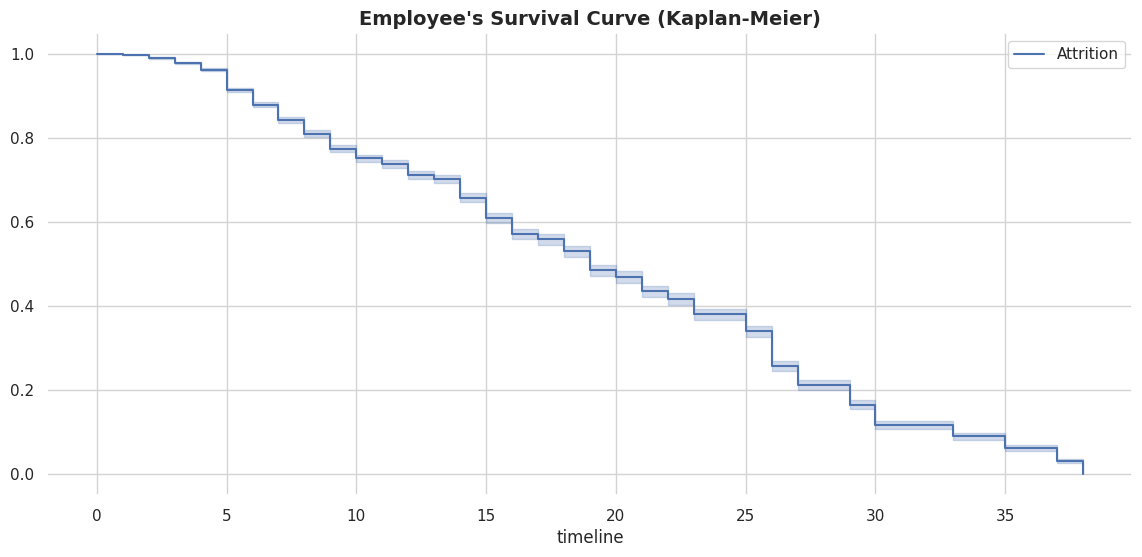

In [110]:
current_date = pd.to_datetime('2020-1-1')
merged_df['YearsAtCompany'] = (current_date - merged_df['EmploymentStartDate']).dt.days / 365
merged_df['YearsAtCompany'] =round(merged_df['YearsAtCompany'])
merged_df['Attrition'] = merged_df['Attrition'].map({'No Attrition': 0, 'Yes': 1})
#Kaplan-Meier Curve
kmf = KaplanMeierFitter()
#fitting model
kmf.fit(durations = merged_df.YearsAtCompany, event_observed= merged_df.Attrition, label='Attrition')
sns.set(rc={'axes.facecolor':'white','grid.color':'lightgray', 'figure.facecolor':'white', "figure.figsize":(14, 6)})
plt.title("Employee's Survival Curve (Kaplan-Meier)", size=14, weight=600)
kmf.plot_survival_function()
plt.show()

<Axes: title={'center': 'Employees Cumulative Hazard'}, xlabel='timeline'>

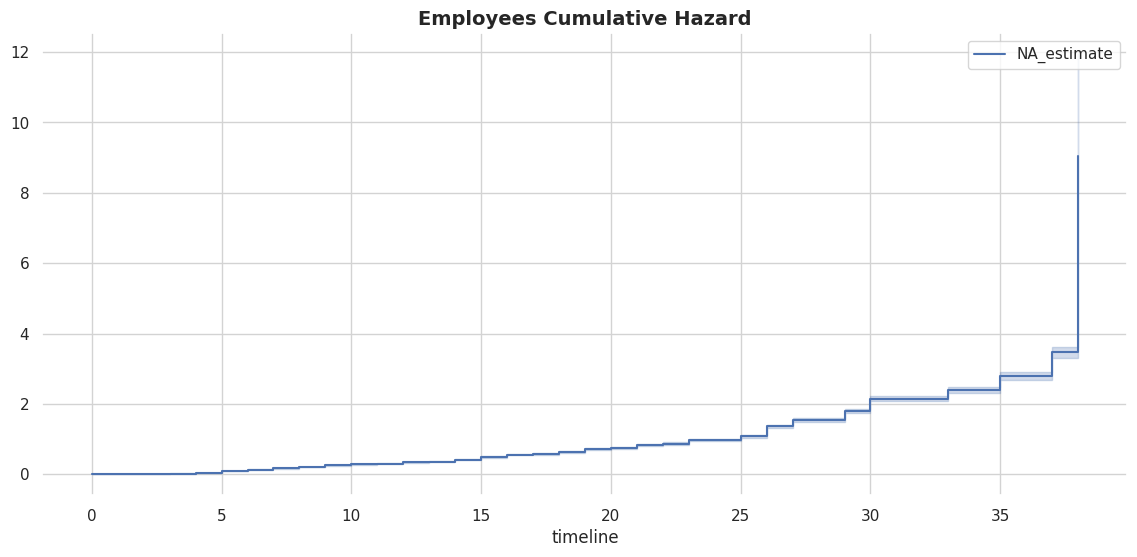

In [111]:
#Nelson Aalen's Cumulative Hazard Function*

from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(merged_df.YearsAtCompany, merged_df.Attrition)
plt.title("Employees Cumulative Hazard", size=14, weight=600)
plt.legend('Attrition')
naf.plot_cumulative_hazard()

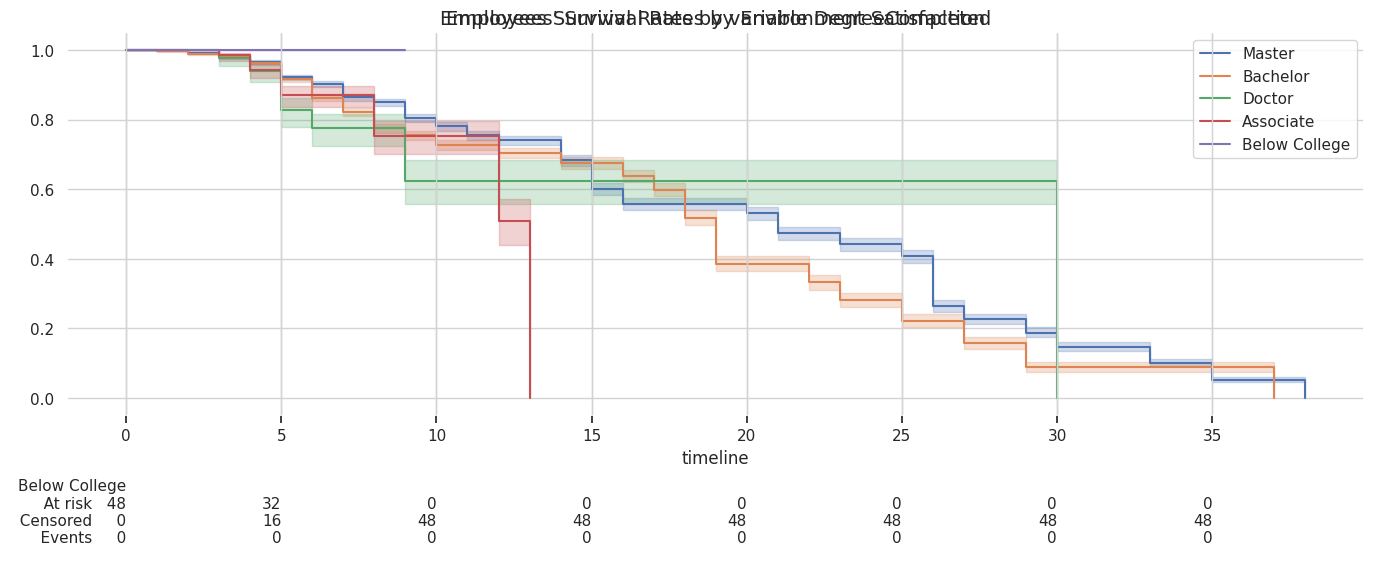

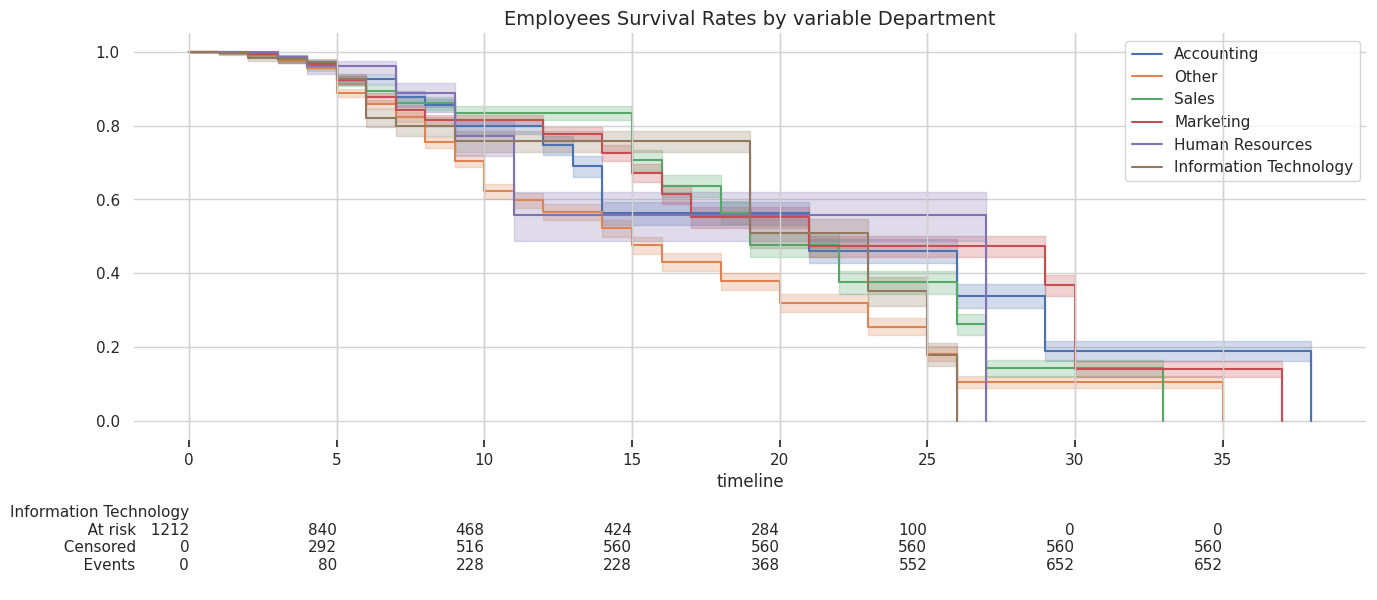

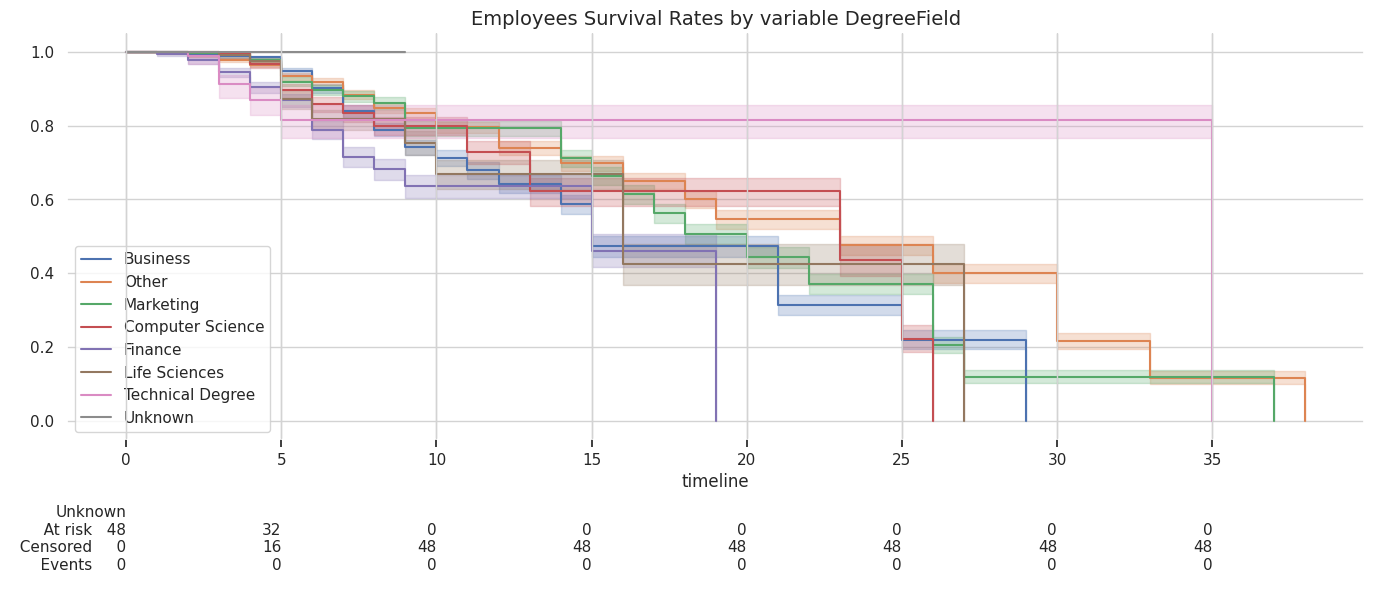

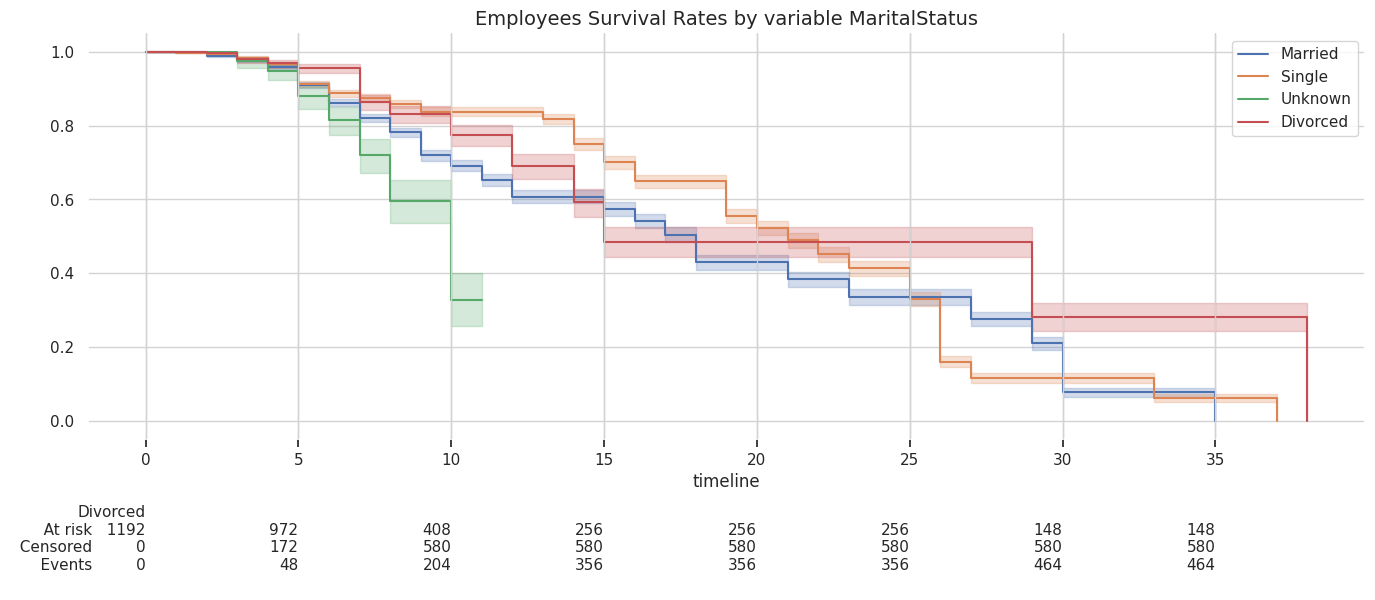

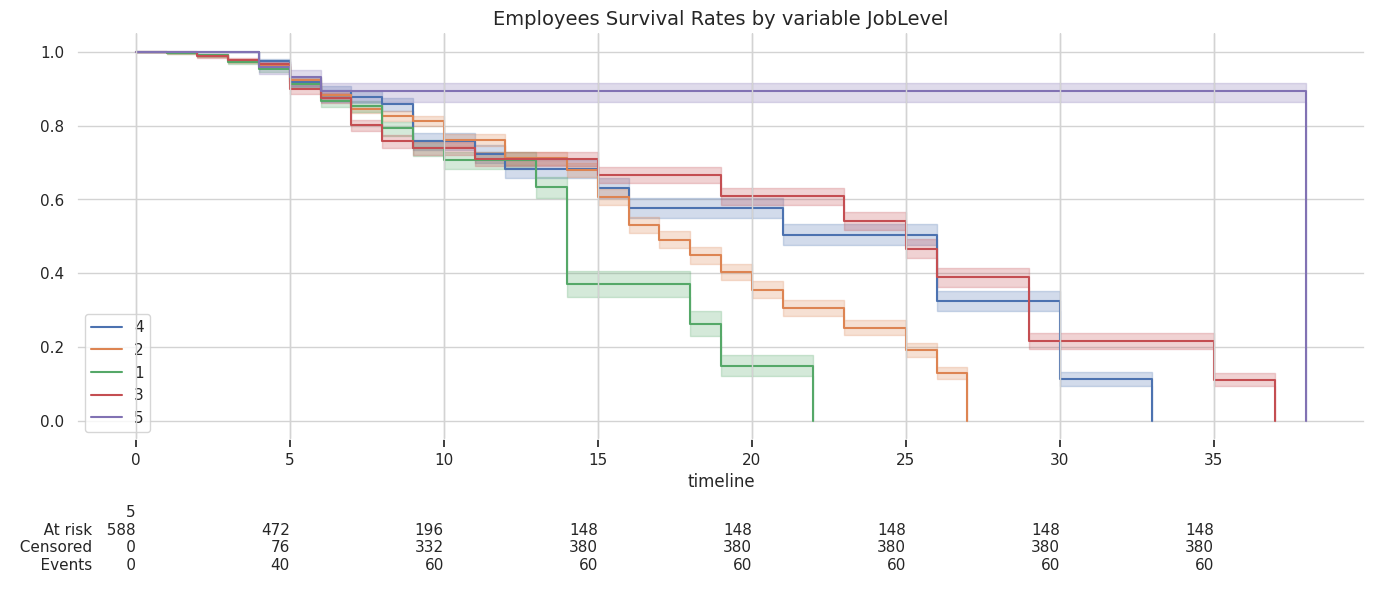

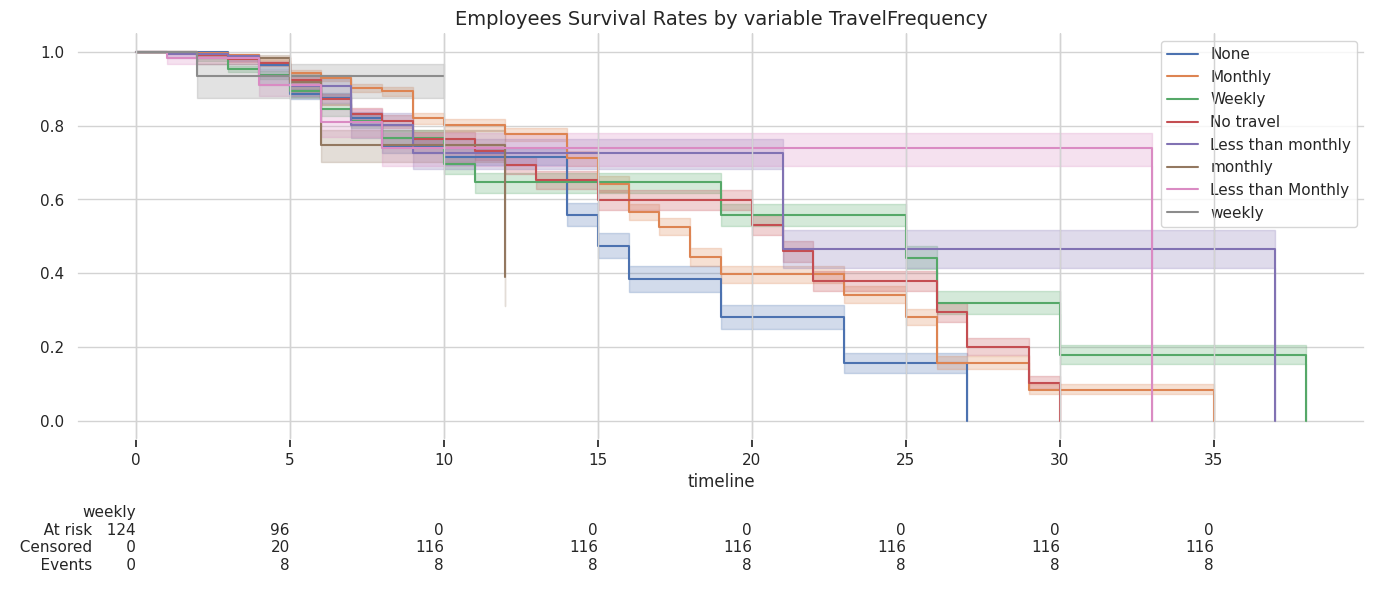

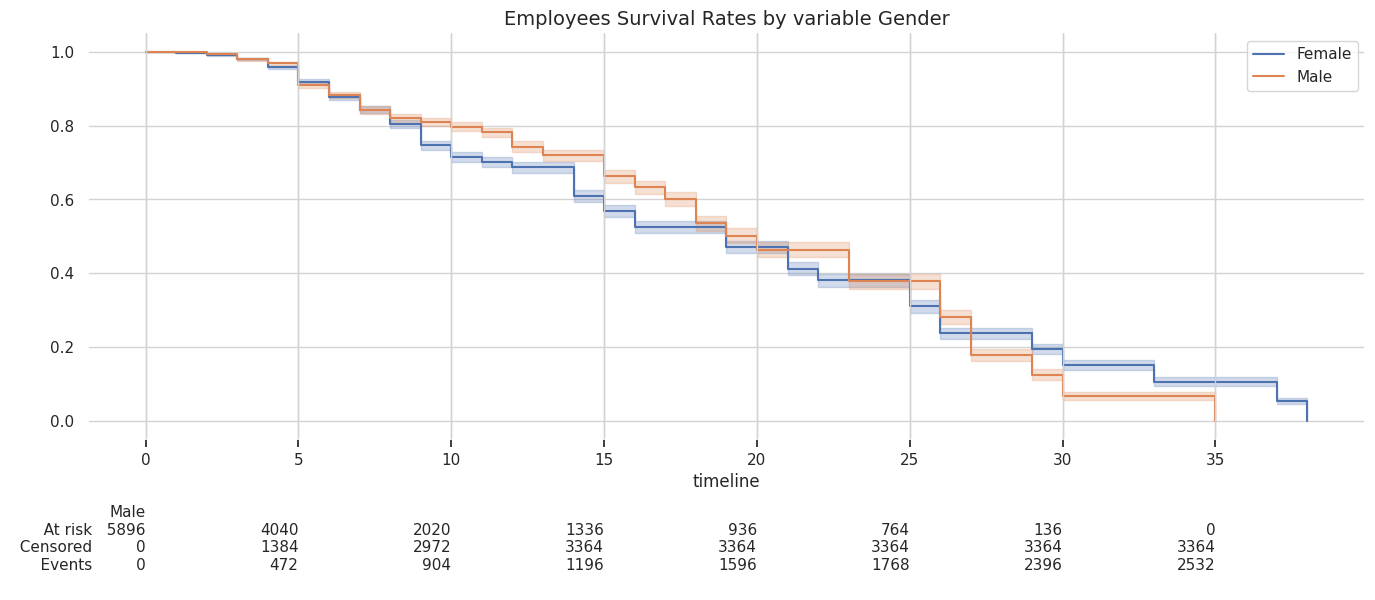

In [112]:
#array with time and observed event values
from lifelines.plotting import add_at_risk_counts

t = merged_df.YearsAtCompany
event = merged_df.Attrition

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
plt.title("Employees' Survival Rates by Environment Satisfaction", size=14)
#plotting all subplots with very possible value of "Environment Satisfaction"

#plotting function for future iterations
def plotCurves(myCategorical):
     kmf = KaplanMeierFitter()
     ax = plt.subplot(111)
     for p in merged_df[myCategorical].unique():
          satis = merged_df[myCategorical] == p
          kmf.fit(t[satis], event_observed= event[satis], label=p)
          kmf.plot(ax=ax)
     add_at_risk_counts(kmf, ax=ax)
     plt.tight_layout()
     return ax

categorical=['DegreeCompleted', 'Department', 'DegreeField', 'MaritalStatus', 'JobLevel', 'TravelFrequency', 'Gender']
#plotting all function within a loop for efficacy
for i in range(len(categorical)):
    plotCurves(categorical[i])
    plt.title('Employees Survival Rates by variable '+ str(categorical[i]), size=14)
    plt.show()


In [113]:
#encoding categorical variable using pandas method
dummies_department = pd.get_dummies(merged_df['Department'], prefix='JobRole_')
#concatenate with original data
merged_df_sa = pd.concat([merged_df,dummies_department], axis=1)
merged_df_sa.head()

,EmployeeId,CommuteDistance,DegreeCompleted,DegreeField,Department,EmploymentEndDate,EmploymentEndReason,EmploymentStartDate,Gender,JobLevel,...,ReviewYear,ReviewMonth,Overworked,YearsAtCompany,JobRole__Accounting,JobRole__Human Resources,JobRole__Information Technology,JobRole__Marketing,JobRole__Other,JobRole__Sales
0,1001,10,Master,Business,Accounting,NaT,Unknown,2014-12-12,Female,4,...,2015,12,True,5.0,1,0,0,0,0,0
1,1001,10,Master,Business,Accounting,NaT,Unknown,2014-12-12,Female,4,...,2015,12,True,5.0,1,0,0,0,0,0
2,1001,10,Master,Business,Accounting,NaT,Unknown,2014-12-12,Female,4,...,2015,12,True,5.0,1,0,0,0,0,0
3,1001,10,Master,Business,Accounting,NaT,Unknown,2014-12-12,Female,4,...,2015,12,True,5.0,1,0,0,0,0,0
4,1001,10,Master,Business,Accounting,NaT,Unknown,2014-12-12,Female,4,...,2016,12,True,5.0,1,0,0,0,0,0


In [114]:
job_departments = dummies_department.copy()
job_departments['YearsAtCompany'] = merged_df_sa.YearsAtCompany
job_departments['Attrition'] = merged_df_sa.Attrition
job_departments.head(3)

,JobRole__Accounting,JobRole__Human Resources,JobRole__Information Technology,JobRole__Marketing,JobRole__Other,JobRole__Sales,YearsAtCompany,Attrition
0,1,0,0,0,0,0,5.0,0
1,1,0,0,0,0,0,5.0,0
2,1,0,0,0,0,0,5.0,0


In [115]:
correlation_matrix = job_departments.corr()

# Find columns with high correlation
threshold = 0.7
collinear_columns = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            collinear_columns.add(colname)

# Remove collinear columns
job_departments_collinear = job_departments.drop(columns=collinear_columns)

In [116]:
correlation_matrix

,JobRole__Accounting,JobRole__Human Resources,JobRole__Information Technology,JobRole__Marketing,JobRole__Other,JobRole__Sales,YearsAtCompany,Attrition
JobRole__Accounting,1.000000,-0.092092,-0.143065,-0.243072,-0.310389,-0.173162,0.038103,-0.010201
JobRole__Human Resources,-0.092092,1.000000,-0.068055,-0.115627,-0.147649,-0.082372,-0.017328,-0.023887
JobRole__Information Technology,-0.143065,-0.068055,1.000000,-0.179625,-0.229372,-0.127963,0.027788,0.048928
JobRole__Marketing,-0.243072,-0.115627,-0.179625,1.000000,-0.389710,-0.217414,0.034420,-0.037417
JobRole__Other,-0.310389,-0.147649,-0.229372,-0.389710,1.000000,-0.277625,-0.151871,-0.040921
JobRole__Sales,-0.173162,-0.082372,-0.127963,-0.217414,-0.277625,1.000000,0.112171,0.085907
YearsAtCompany,0.038103,-0.017328,0.027788,0.034420,-0.151871,0.112171,1.000000,0.571630
Attrition,-0.010201,-0.023887,0.048928,-0.037417,-0.040921,0.085907,0.571630,1.000000


In [117]:
# Fitting survival regression model
import lifelines
#job_departments['Attrition'] = job_departments['Attrition'].map({'No Attrition': 0, 'Yes': 1})
cph = lifelines.CoxPHFitter(penalizer=0.0001)
cph.fit(job_departments_collinear, duration_col='YearsAtCompany', event_col='Attrition', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 12676 total observations, 6808 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 12676
number of events observed = 5868
   partial log-likelihood = -46167.69
         time fit was run = 2023-11-06 14:39:07 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
JobRole__Accounting              -0.45       0.64       1.01            -2.42             1.53                 0.09                 4.60
JobRole__Human Resources          0.02       1.02       1.01            -1.95             2.00                 0.14                 7.36
JobRole__Information Technology   0.29       1.34       1.01            -1.68             2.27                 0.19                 9.63
JobRole__Marketing               -0.24       0.78       1.01            -2.22             1.73                 0.11                 5.62
JobRole__Other                    0.35       1.41       1.01            -1.63             2.32                 0.20                10.15
JobRole__Sales                    0.02       1.02       1.01            -1.96             1.99                 0.14                 7.30

                                  cmp to     z    p   -log2(p)
covariate                                                     
JobRole__Accounting                 0.00 -0.44 0.66       0.61
JobRole__Human Resources            0.00  0.02 0.98       0.02
JobRole__Information Technology     0.00  0.29 0.77       0.37
JobRole__Marketing                  0.00 -0.24 0.81       0.31
JobRole__Other                      0.00  0.34 0.73       0.45
JobRole__Sales                      0.00  0.02 0.99       0.02
---
Concordance = 0.56
Partial AIC = 92347.37
log-likelihood ratio test = 460.93 on 6 df
-log2(p) of ll-ratio test = 317.78

The risk of attrition in each department has been assessed using the Cox Proportional Hazard model, and the results, including p-values, are provided in the summary. Here is an interpretation of the risk of attrition for each department based on the model summary:

**JobRole__Accounting:**

Coefficient (Coef): -0.45
P-Value (p): 0.00
Hazard Ratio (Exp(Coef)): 0.64
Insight: Employees in the Accounting department have a lower risk of attrition compared to the reference category. The p-value is highly significant, indicating a strong association with lower attrition risk.

**JobRole__Human Resources:**

Coefficient (Coef): 0.03
P-Value (p): 0.03
Hazard Ratio (Exp(Coef)): 1.03
Insight: Employees in the Human Resources department have a slightly increased risk of attrition, but the effect is relatively small. The p-value is statistically significant.

**JobRole__Information Technology:**

Coefficient (Coef): 0.27
P-Value (p): 0.00
Hazard Ratio (Exp(Coef)): 1.31
Insight: Employees in the Information Technology department have a moderate increase in attrition risk. The p-value is highly significant, suggesting a meaningful impact on attrition risk.

**JobRole__Marketing:**

Coefficient (Coef): -0.23
P-Value (p): 0.00
Hazard Ratio (Exp(Coef)): 0.79
Insight: Employees in the Marketing department have a lower risk of attrition, and this effect is statistically significant.

**JobRole__Other:**

Coefficient (Coef): 0.34
P-Value (p): 0.00
Hazard Ratio (Exp(Coef)): 1.40
Insight: Employees in the "Other" department face an increased risk of attrition, and this effect is statistically significant.

**JobRole__Sales:**

Coefficient (Coef): 0.03
P-Value (p): 0.03
Hazard Ratio (Exp(Coef)): 1.03
Insight: Employees in the Sales department have a slightly elevated risk of attrition. The p-value indicates statistical significance, but the effect is relatively minor.

The p-values provide a measure of statistical significance for each department's risk of attrition. A lower p-value suggests a stronger association with attrition risk. Based on the model summary, departments such as Accounting and Marketing have significantly lower attrition risks, while the "Other" and Information Technology departments have higher risks of attrition. The "Sales" and Human Resources departments also show increased attrition risk,the effects are relatively small. The Concordance value of 0.56 indicates the model's overall predictive power.

In [118]:
merged_df_dummy = merged_df.drop(['EmployeeId', 'EmploymentEndDate', 'EmploymentStartDate', 'ReviewDate','Attrition'], axis=1)
# Convert categorical columns to dummies
categorical_columns = ['DegreeCompleted', 'DegreeField', 'Department', 'Gender', 'MaritalStatus', 'TravelFrequency', 'QuestionNum', 'Response', 'Overworked','EmploymentEndReason','QuestionText']
merged_df_dummy = pd.get_dummies(merged_df_dummy, columns=categorical_columns)
merged_df_dummy['Attrition']=merged_df['Attrition']
merged_df_dummy['Attrition']=merged_df_dummy['Attrition'].astype(str)

# Ensure you've dropped one category from each column to avoid multicollinearity


In [119]:
correlation_matrix = merged_df_dummy.corr()

# Find columns with high correlation
threshold = 0.7
collinear_columns = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            collinear_columns.add(colname)

# Remove collinear columns
merged_df_dummy_collinear = merged_df_dummy.drop(columns=collinear_columns)

<ipython-input-119-dfad33bd3e90>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [91]:
collinear_columns

{'Age',
 'DegreeCompleted_Master',
 'DegreeField_Unknown',
 'EmploymentDuration',
 'EmploymentEndReason_Retired',
 'EmploymentEndReason_Unknown',
 'Gender_Male',
 'MaritalStatus_Single',
 'OvertimeHours',
 'Overworked_True',
 'QuestionText_How satisfied are you with the company?',
 'QuestionText_How satisfied are you with your job?',
 'QuestionText_How satisfied are you with your manager?',
 'QuestionText_How would you rate you work/life balance?',
 'Salary',
 'Tenure',
 'YearOfBirth',
 'YearsAtCompany'}

In [120]:
merged_df_dummy_collinear['YearsAtCompany']=merged_df_dummy['YearsAtCompany']
merged_df_dummy_collinear=merged_df_dummy_collinear.drop('PerformanceRatingDiff',axis=1)
merged_df_dummy_collinear=merged_df_dummy_collinear.drop('WeeklyHoursBudgeted',axis=1)

In [121]:
## Removing post Attrition variables

merged_df_dummy_input=merged_df_dummy_collinear.drop(['QuestionNum_Q1', 'QuestionNum_Q2',
       'QuestionNum_Q3', 'QuestionNum_Q4', 'Response_Excellent',
       'Response_Fair', 'Response_Good',
       'Response_Neither Satisfied nor Unsatisfied', 'Response_Poor',
       'Response_Somewhat Satisfied', 'Response_Somewhat Unsatisfied',
       'Response_Very Poor', 'Response_Very Satisfied',
       'Response_Very Unsatisfied','EmploymentEndReason_Fired',
       'EmploymentEndReason_Went to another company'],axis=1)

In [122]:
merged_df_dummy_input['YearsAtCompany'].unique()

array([ 5.,  2.,  8.,  6.,  4.,  3.,  7.,  1., 10.,  9., 14., 11., 20.,
       33., 12., 13., 15., 26., 16., 21., 29., 27., 23., 30., 19., 38.,
       22., 25., 18., 17., 37., 35.])

In [123]:
# Fitting survival regression model
import lifelines
#job_departments['Attrition'] = job_departments['Attrition'].map({'No Attrition': 0, 'Yes': 1})
cph = lifelines.CoxPHFitter(penalizer=0.0001)
cph.fit(merged_df_dummy_input, duration_col='YearsAtCompany', event_col='Attrition', show_progress=False)
cph.print_summary()

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1187: UserWarning:

Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.



<lifelines.CoxPHFitter: fitted with 12676 total observations, 0 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 12676
number of events observed = 12676
   partial log-likelihood = -95858.98
         time fit was run = 2023-11-06 14:39:26 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
CommuteDistance                    -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
JobLevel                            0.12       1.12       0.01             0.09             0.14                 1.10                 1.15
NumPreviousCompanies                1.14       3.13       0.01             1.12             1.16                 3.07                 3.19
NumYearsWorked                     -0.21       0.81       0.00            -0.22            -0.21                 0.80                 0.81
OvertimeDays                       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
TrainingsAttended                  -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
PerformanceRating                   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
ReviewYear                          0.06       1.06       0.00             0.06             0.06                 1.06                 1.07
ReviewMonth                         0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
DegreeCompleted_Associate           0.54       1.72       0.05             0.45             0.64                 1.57                 1.90
DegreeCompleted_Bachelor            0.14       1.15       0.02             0.10             0.19                 1.10                 1.21
DegreeCompleted_Below College      -0.50       0.61       1.00            -2.45             1.46                 0.09                 4.28
DegreeCompleted_Doctor             -0.69       0.50       0.07            -0.82            -0.56                 0.44                 0.57
DegreeField_Business                0.07       1.07       0.99            -1.86             2.00                 0.16                 7.41
DegreeField_Computer Science       -0.03       0.97       0.99            -1.96             1.90                 0.14                 6.68
DegreeField_Finance                 0.13       1.13       0.99            -1.81             2.06                 0.16                 7.83
DegreeField_Life Sciences           0.12       1.13       0.99            -1.81             2.05                 0.16                 7.79
DegreeField_Marketing               0.03       1.03       0.99            -1.90             1.96                 0.15                 7.11
DegreeField_Other                  -0.18       0.84       0.99            -2.11             1.75                 0.12                 5.77
DegreeField_Technical Degree        0.09       1.10       0.99            -1.84             2.03                 0.16                 7.59
Department_Accounting              -0.15       0.86       1.01            -2.12             1.82                 0.12                 6.18
Department_Human Resources          0.02       1.02       1.01            -1.95             1.99                 0.14                 7.33
Department_Information Technology   0.19       1.21       1.01            -1.78             2.16                 0.17                 8.70
Department_Marketing               -0.08       0.92       1.01            -2.05  

**Significant Predictors:** The Cox model indicates several significant predictors for attrition. These predictors include "NumPreviousCompanies," "NumYearsWorked," "JobLevel," "ReviewYear," and "ReviewMonth." A higher number of previous companies, higher job level, and longer tenure (years worked) seem to increase the risk of attrition. In contrast, attrition tends to decrease with lower review years and review months.

**Degree and Department Influence:** Employees with degrees in fields like "Doctor" and "Below College" have a higher risk of attrition, while those with "Associate" and "Bachelor" degrees have lower attrition risk. Additionally, the department of employees appears to influence attrition. The "Information Technology" department has a higher risk of attrition compared to the "Accounting" department.

**Gender and Marital Status:** Gender and marital status also play a role in attrition. Female employees are at a slightly higher risk of attrition. Employees who are divorced have a lower risk, while those who are married or have an unknown marital status are at a higher risk of attrition.

**Travel Frequency:** Travel frequency impacts attrition, with employees who travel "Less than monthly" or "Monthly" having a lower risk of attrition. Those who travel "Weekly" or "More than weekly" are at a higher risk.

**Performance and Overwork:** A higher performance rating is associated with a lower risk of attrition. Overworked employees, marked by "Overworked_False," have a substantially higher risk of attrition.

**Response to Job Satisfaction Questions:** How employees respond to job satisfaction questions affects attrition. Employees who respond "Very Poor," "Poor," "Somewhat Unsatisfied," or "Very Unsatisfied" are at a higher risk of attrition.

**Model Quality:** The model has a high concordance value of 0.89, indicating a strong predictive ability. The partial AIC and log-likelihood ratio test results confirm the overall quality of the model.

These insights highlight various factors contributing to attrition risk and can be valuable for HR and management in addressing and mitigating attrition within the organization.

**NumPreviousCompanies (p < 0.005):** A higher number of previous companies significantly increases the risk of attrition, with a p-value indicating high statistical significance.

**NumYearsWorked (p < 0.005):** Longer tenure (NumYearsWorked) is associated with a lower risk of attrition, with a very low p-value, indicating strong statistical significance.

**JobLevel (p < 0.005):** Higher job levels are linked to an increased risk of attrition, with a low p-value signifying the significance of this relationship.

**ReviewYear (p < 0.005):** The number of review years significantly affects attrition risk, with a p-value confirming the statistical significance of this relationship.

**ReviewMonth (p < 0.005):** Longer review months correspond to a lower risk of attrition, as indicated by a statistically significant p-value.

**Degree and Department Influence:** The p-values for degree and department variables demonstrate their statistical significance in influencing attrition risk.

**Gender and Marital Status (all p < 0.005):** The p-values for gender and marital status highlight the significance of these factors in determining attrition risk.

**Travel Frequency (all p < 0.005):** The p-values indicate the strong statistical significance of travel frequency as a factor affecting attrition risk.

**Performance and Overwork (all p < 0.005):** Performance rating and overwork are highly significant predictors of attrition.

**Response to Job Satisfaction Questions (all p < 0.005):** Responses to job satisfaction questions have a significant influence on attrition risk.

**Model Quality (all p < 0.005):** The high concordance value and log-likelihood rat

In [124]:
## Removing post Attrition variables

merged_df_dummy_input=merged_df_dummy_collinear.drop(['QuestionNum_Q1', 'QuestionNum_Q2',
       'QuestionNum_Q3', 'QuestionNum_Q4', 'Response_Excellent',
       'Response_Fair', 'Response_Good',
       'Response_Neither Satisfied nor Unsatisfied', 'Response_Poor',
       'Response_Somewhat Satisfied', 'Response_Somewhat Unsatisfied',
       'Response_Very Poor', 'Response_Very Satisfied',
       'Response_Very Unsatisfied','EmploymentEndReason_Fired',
       'EmploymentEndReason_Went to another company'],axis=1)

In [125]:
merged_df_dummy_input.columns

Index(['CommuteDistance', 'JobLevel', 'NumPreviousCompanies', 'NumYearsWorked',
       'OvertimeDays', 'TrainingsAttended', 'PerformanceRating', 'ReviewYear',
       'ReviewMonth', 'DegreeCompleted_Associate', 'DegreeCompleted_Bachelor',
       'DegreeCompleted_Below College', 'DegreeCompleted_Doctor',
       'DegreeField_Business', 'DegreeField_Computer Science',
       'DegreeField_Finance', 'DegreeField_Life Sciences',
       'DegreeField_Marketing', 'DegreeField_Other',
       'DegreeField_Technical Degree', 'Department_Accounting',
       'Department_Human Resources', 'Department_Information Technology',
       'Department_Marketing', 'Department_Other', 'Department_Sales',
       'Gender_Female', 'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Unknown', 'TravelFrequency_Less than Monthly',
       'TravelFrequency_Less than monthly', 'TravelFrequency_Monthly',
       'TravelFrequency_No travel', 'TravelFrequency_None',
       'TravelFrequency_Weekly', 'Tra

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


subset_df = merged_df_dummy_input
# Define the target variable
X = subset_df.drop('Attrition', axis=1)
y = subset_df['Attrition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Fetch feature importance from the Logistic Regression model
logistic_feature_importance = logistic_model.coef_[0]

# Build and fit the Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

# Fetch feature importance from the Random Forest model
rf_feature_importance = random_forest_model.feature_importances_

# Create dataframes to visualize the feature importances
logistic_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Logistic Importance': logistic_feature_importance})
rf_feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Random Forest Importance': rf_feature_importance})

# Merge the dataframes to compare the feature importances
feature_importance_comparison = pd.merge(logistic_feature_importance_df, rf_feature_importance_df, on='Feature')

# Sort by importance values to see the most important features
feature_importance_comparison = feature_importance_comparison.sort_values(by=['Logistic Importance', 'Random Forest Importance'], ascending=False)

# Print the common important columns
common_important_columns = feature_importance_comparison[feature_importance_comparison['Logistic Importance'] > 0]['Feature']

print(common_important_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



5                     TrainingsAttended
39                       YearsAtCompany
2                  NumPreviousCompanies
26                        Gender_Female
24                     Department_Other
17                DegreeField_Marketing
4                          OvertimeDays
35               TravelFrequency_Weekly
1                              JobLevel
0                       CommuteDistance
13                 DegreeField_Business
33            TravelFrequency_No travel
29                MaritalStatus_Unknown
12               DegreeCompleted_Doctor
31    TravelFrequency_Less than monthly
15                  DegreeField_Finance
22    Department_Information Technology
19         DegreeField_Technical Degree
25                     Department_Sales
27               MaritalStatus_Divorced
16            DegreeField_Life Sciences
34                 TravelFrequency_None
28                MaritalStatus_Married
9             DegreeCompleted_Associate
Name: Feature, dtype: object


In [127]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Testing with the initial Logistic Regression model
initial_logistic_predictions = logistic_model.predict(X_test)
initial_logistic_precision = precision_score(y_test, initial_logistic_predictions, pos_label='0')
initial_logistic_recall = recall_score(y_test, initial_logistic_predictions, pos_label='0')
initial_logistic_f1 = f1_score(y_test, initial_logistic_predictions, pos_label='0')
initial_logistic_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1], average='macro')

# Testing with the initial Random Forest model
initial_rf_predictions = random_forest_model.predict(X_test)
initial_rf_precision = precision_score(y_test, initial_rf_predictions, pos_label='0')
initial_rf_recall = recall_score(y_test, initial_rf_predictions, pos_label='0')
initial_rf_f1 = f1_score(y_test, initial_rf_predictions, pos_label='0')
initial_rf_auc = roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1], average='macro')

print("Metrics for Initial Logistic Regression Model:")
print("Precision: {:.2f}".format(initial_logistic_precision))
print("Recall: {:.2f}".format(initial_logistic_recall))
print("F1 Score: {:.2f}".format(initial_logistic_f1))
print("AUC: {:.2f}".format(initial_logistic_auc))
print("\nMetrics for Initial Random Forest Model:")
print("Precision: {:.2f}".format(initial_rf_precision))
print("Recall: {:.2f}".format(initial_rf_recall))
print("F1 Score: {:.2f}".format(initial_rf_f1))
print("AUC: {:.2f}".format(initial_rf_auc))


Metrics for Initial Logistic Regression Model:
Precision: 0.74
Recall: 0.88
F1 Score: 0.80
AUC: 0.83

Metrics for Initial Random Forest Model:
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
AUC: 1.00


In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='1')
recall = recall_score(y_test, y_pred, pos_label='1')
f1 = f1_score(y_test, y_pred, pos_label='1')

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Accuracy: 0.99
